In [127]:
import numpy as np
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig

# Základy
## Načtení tónů
Následující kód je přímo nezměněný ze zadání (bez importů). Provede načtení 0.5s dlouhého úseku z každého tónu (s přeskočením prvních 0.25s, aby nebyl slyšet úder kladívka). 

In [128]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('../klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) 
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x)
    xall[tone, :] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone

## Načtení `midi.txt`
Následující kód čte a parsuje soubor `midi.txt` (obsahující tóny a odpovídající frekvence) pomocí knihovny Pandas. Soubor se naparsuje jako CSV s oddělovačem tab. Midi tón se použije pro indexování.

In [129]:
midi = pd.read_csv('midi.txt', sep='\t', header=None, index_col=0, names=['midi', 'freq'])

## Načtení `xkucha28.txt`
Následující kód čte a parsuje soubor `xkucha28.txt` (obsahující přidělené midi tóny). Jednotlivé tóny se načtou, převedou na číslo a z minulého kroku se zjistí základní frekvence. Tóny s frekvencí jsou uloženy v poli jako tuple

In [130]:
xkucha28 = list(map(int, open('xkucha28.txt', 'r').read().strip().split(' ')))
xkucha28t = [(x, midi['freq'][x]) for x in xkucha28]
xkucha28t

[(39, 77.78), (54, 185.0), (101, 2793.83)]

## Zobrazení 3 period
Pro každou frekvenci vypočítám délku 3 period a následně tento úsek zobrazím.

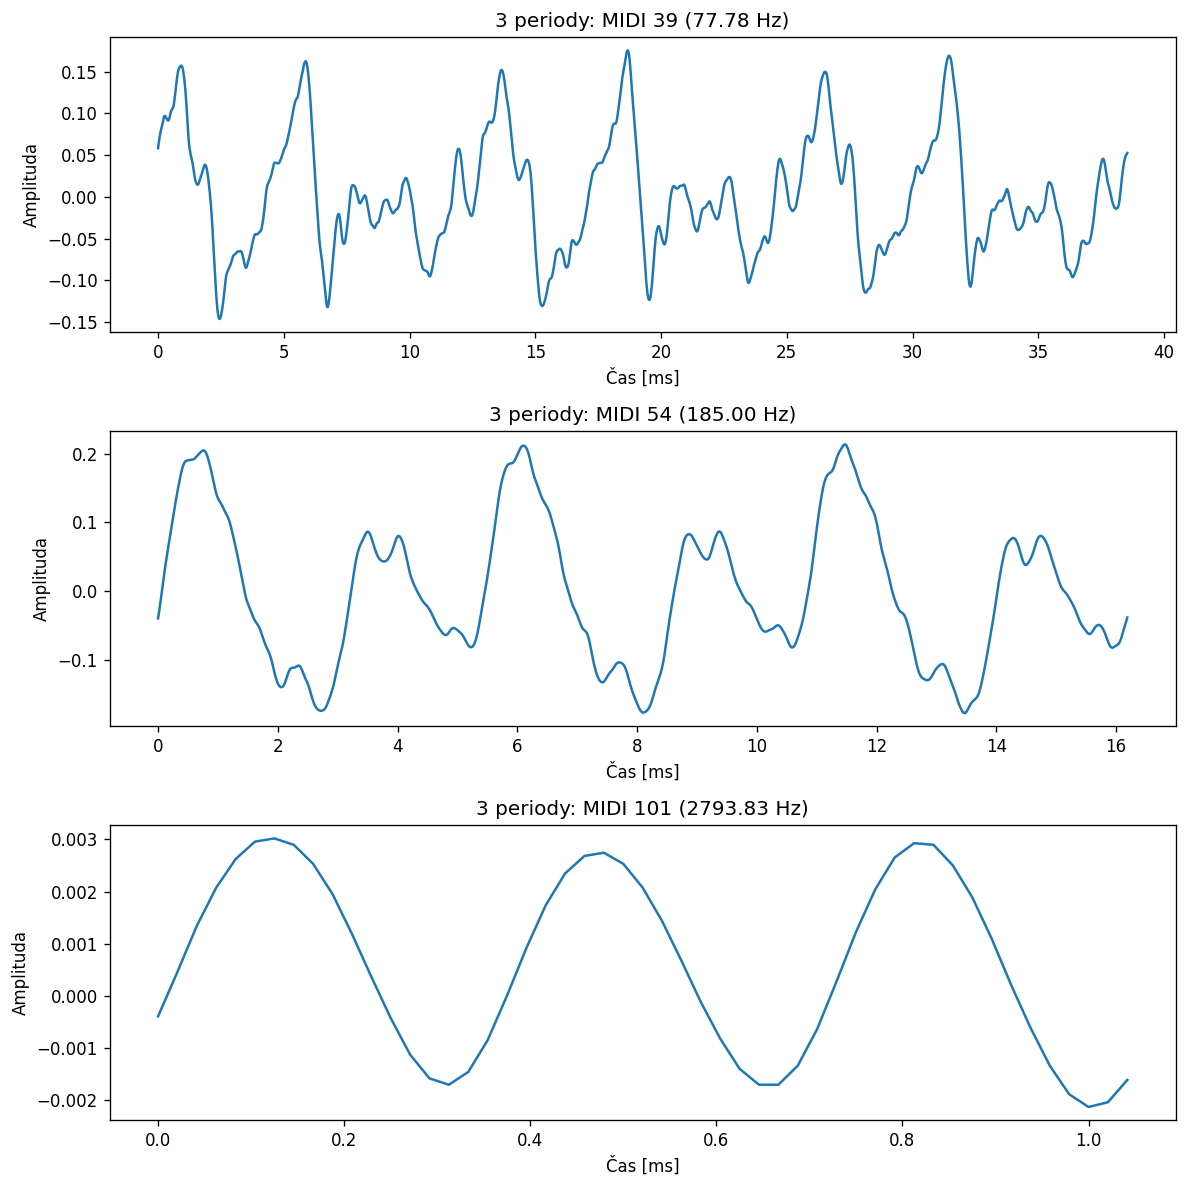

In [131]:
plt.figure(figsize=(10, 10), dpi=120)
for i, (tone, freq) in enumerate(xkucha28t):
    three_periods = int(Fs / freq * 3)
    plt.subplot(3, 1, i+1)
    plt.plot(1000 * np.arange(0, three_periods) / Fs, xall[tone, :three_periods])
    plt.title(f"3 periody: MIDI {tone} ({freq:.2f} Hz)")
    plt.xlabel("Čas [ms]")
    plt.ylabel("Amplituda")
plt.tight_layout()


## Spočítání a zobrazení DFT
Pomocí numpy spočítáme DFT pro každý signál. K signálu jsem podle zadání pryčetl konstantu $10^{-5}$, aby se dalo spektrum pěkně zobrazit.

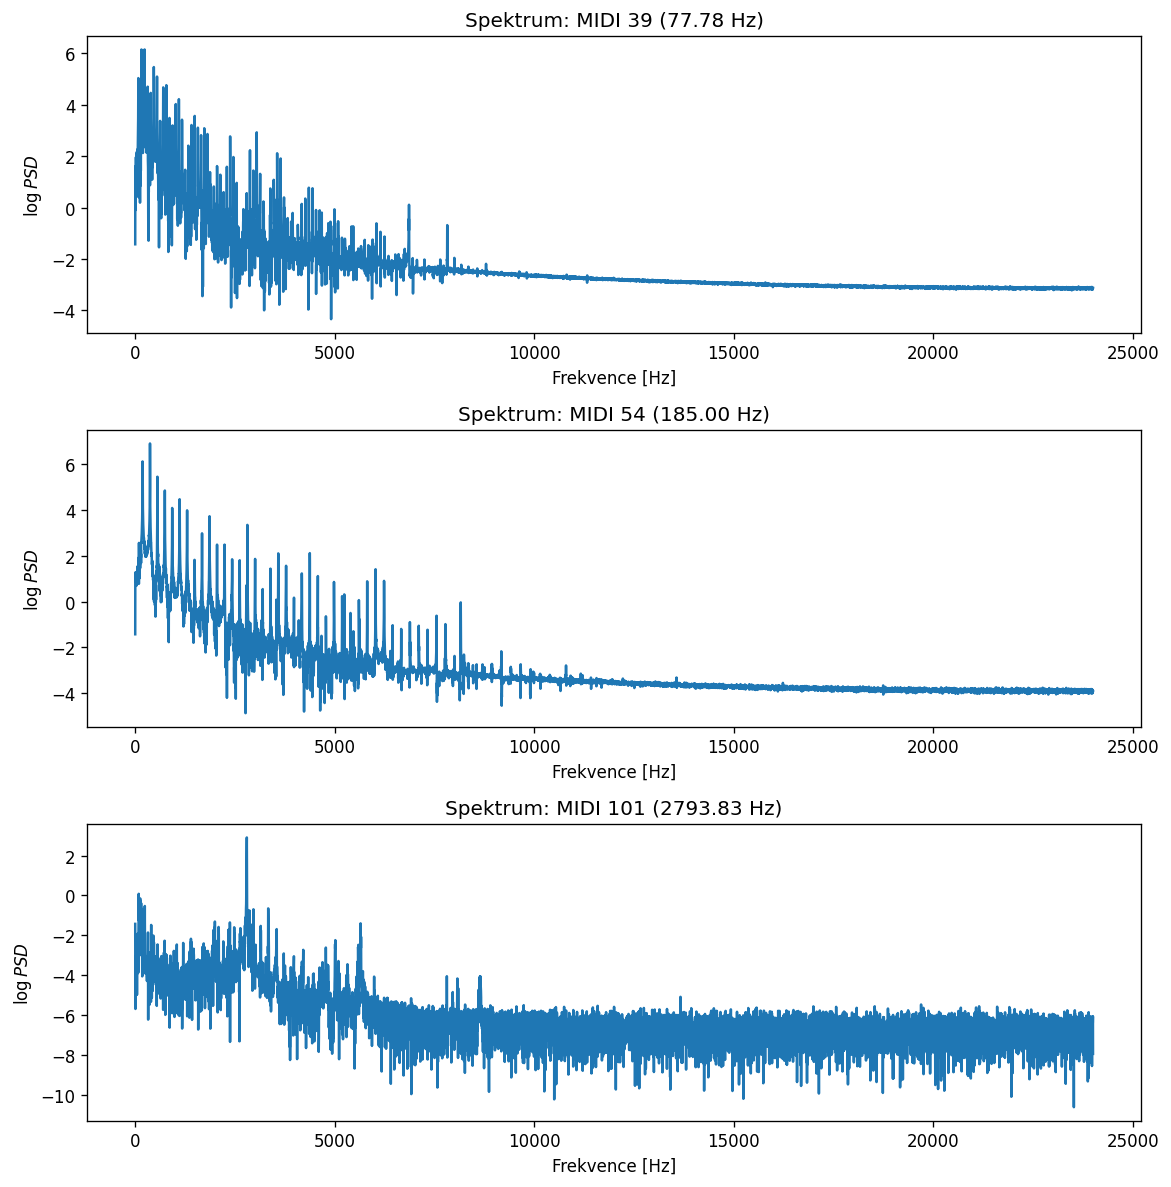

In [132]:
plt.figure(figsize=(10, 10), dpi=120)
for i, (tone, freq) in enumerate(xkucha28t):
    fft = np.log(np.abs(np.fft.fft(xall[tone] + 1e-5)))
    plt.subplot(3, 1, i+1)
    plt.plot(np.arange(0, Fs / 2, 2), fft[:len(fft)//2])
    plt.title(f"Spektrum: MIDI {tone} ({freq:.2f} Hz)")
    plt.xlabel("Frekvence [Hz]")
    plt.ylabel("$\log PSD$")
plt.tight_layout()


## Uložení tónů

In [133]:
names = ['a', 'b', 'c']
for i, tone in enumerate(xkucha28):
    sf.write(f'../audio/{names[i]}_orig.wav', xall[tone], Fs)

# Určení základní frekvence
Pro určení základní frekvence pro každý tón jsem použil dvě metody. Pro frekvence do 800Hz jsem použil autokorelaci a pro frekvence nad 800Hz jsem použil DFT. Jak zadání napovídá, tak autokorelace selhávala při vyšších frekvencích (vycházela například poloviční frekvence). Hranici 800Hz jsem zjistil experimentálně. Vzorec pro kalkulaci základní frekvence při využití autokorelace: 
$$f_0 = \frac{F_S}{L}$$

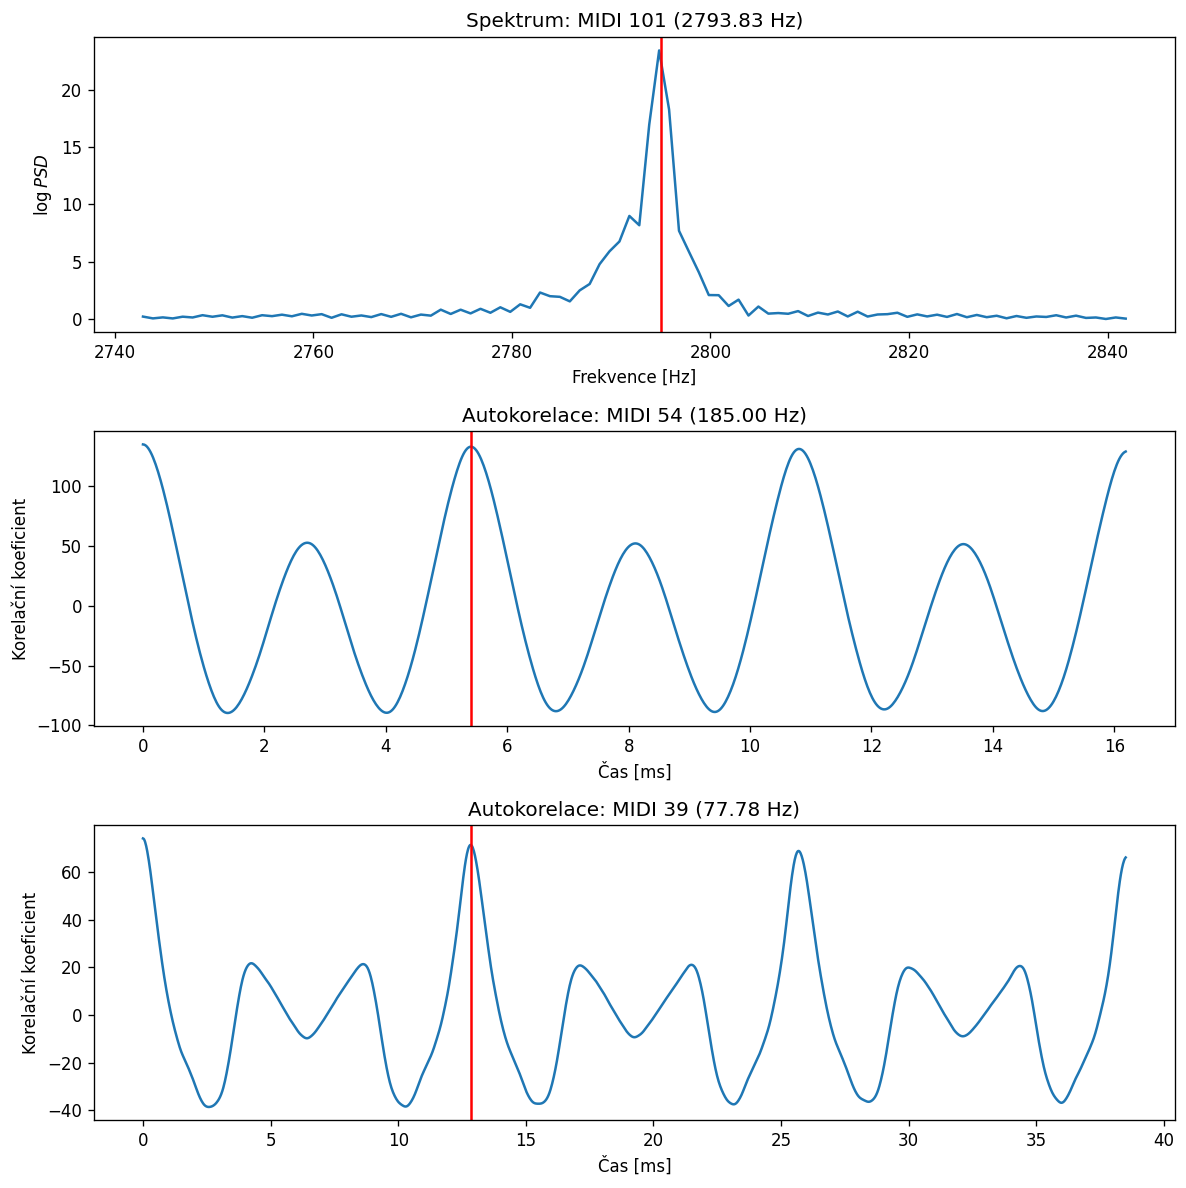

In [134]:
data = []
estimates = np.zeros(MIDITO + 1)
i = 1
plt.figure(figsize=(10, 10), dpi=120)
for tone, freq in midi.iterrows():
    f = 0
    if freq['freq'] < 800:
        c = sig.correlate(xall[tone], xall[tone], mode='full')
        c = c[len(c)//2:]
        d = np.diff(c)
        start = np.nonzero(d > 0)[0][0]
        peak = np.argmax(c[start:]) + start
        f = Fs / peak
        if tone in xkucha28:
            plt.subplot(3, 1, i)
            plt.plot(np.linspace(0, 1000 * peak * 3 / Fs, peak*3), c[:peak*3])
            plt.title(f"Autokorelace: MIDI {tone} ({freq['freq']:.2f} Hz)")
            plt.xlabel("Čas [ms]")
            plt.ylabel("Korelační koeficient")
            plt.axvline(1000 * peak / Fs, color='red')
            i += 1
    else:
        fft = np.abs(np.fft.fft(xall[tone], Fs))
        fft = fft[:len(fft)//2]
        f = np.argmax(fft)
        if tone in xkucha28:
            offset = 50
            space = np.arange(freq['freq'] - offset - 1, freq['freq'] + offset - 1)
            plt.subplot(3, 1, i)
            plt.plot(space, fft[int(freq['freq']) - offset:int(freq['freq'] + offset)])
            plt.title(f"Spektrum: MIDI {tone} ({freq['freq']:.2f} Hz)")
            plt.xlabel("Frekvence [Hz]")
            plt.ylabel("$\log PSD$")
            plt.axvline(f, color='red')
            i += 1
    data.append([f, freq['freq'], 100 * abs(f - freq['freq']) / freq['freq']])
    estimates[tone] = f
est_stats = pd.DataFrame(data=data, columns=['Calculated', 'Expected', 'Error %'])
plt.tight_layout()

## Chyba při prvotním určení frekvence
Zde je tabulka se statistikou chyby napříč všemi frekvencemi. Dle mého je prvotní odhad frekvence velice slušný (Průměrná chyba 0.2%, maximální chyba 0.5%). Primární chyba vzniká kvůli rozlišení DFT/autokorelace. U DFT v následujícím kroku odhad zlepším, u autokorelace by se dala použít interpolace.

In [135]:
est_stats['Error %'].describe()

count    85.000000
mean      0.209296
std       0.148492
min       0.023285
25%       0.065841
50%       0.195465
75%       0.334238
max       0.544617
Name: Error %, dtype: float64

# Zpřesnění odhadu základní frekvence $f_0$
Pro zpřesnění odhadu základní frekvence jsem používám DTFT. Počítám 100 centů kolem MIDI frekvence. Frekvence do 100Hz jsem nezpřesňoval, protože se to neukázalo jako funkční řešení a akorát to zhoršovalo původní odhad pomocí autokorelace.

In [136]:
data = []
hundred_cent = 2**(100/1200)
for tone, freq in midi.iterrows(): 
    if freq['freq'] < 100:
        f = estimates[tone]
        data.append([f, freq['freq'], 100 * abs(f - freq['freq']) / freq['freq']])
        continue
    FREQPOINTS = 500
    N = int(Fs / 2)
    n = np.arange(0, N)
    start = freq['freq'] / hundred_cent
    end = freq['freq'] * hundred_cent
    fsweep = np.linspace(start, end, FREQPOINTS)
    A = np.zeros([FREQPOINTS, N], dtype=complex)
    for k in np.arange(0, FREQPOINTS):
        A[k, :] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)
    Xdtft = np.matmul(A, xall[tone].T)
    f = fsweep[np.argmax(np.abs(Xdtft))]
    estimates[tone] = f
    data.append([f, freq['freq'], 100 * abs(f - freq['freq']) / freq['freq']])
est_stats2 = pd.DataFrame(data=data, columns=['Calculated', 'Expected', 'Error %'])


## Chyba po zlepšení odhadu základní frekvence
Po zlepšení odhadu základní frekvence se průměrná chyba výrazně snížila.

In [137]:
print(est_stats2['Error %'].describe())


count    85.000000
mean      0.138748
std       0.139544
min       0.006860
25%       0.039468
50%       0.062632
75%       0.238501
max       0.505522
Name: Error %, dtype: float64


# Reprezentace klavíru


Pro reprezentaci všech tonů si spočítám koeficienty na násobcích základní frekvence. Tyto koeficienty z komplexního čísla převedu na absolutní hodnotu a fázi, které jsou uloženy v tuple. Tedy mám 5 tuplů pro každý tón. Na ukázku je zde vypsaná reprezentace zadaných tonů.

In [138]:
data = []
n = np.arange(0, Fs/2)
for tone, freq in midi.iterrows():
    current = []
    for k in range(1, 6):
        omega = 2 * np.pi * k * estimates[tone] / Fs
        sum = np.sum(xall[tone] * np.exp(-1j * omega * n))
        current.append((np.abs(sum), np.angle(sum)))
    data.append(current)
midi['representation'] = data
for tone in xkucha28:
    print(midi['representation'][tone])

[(161.515505916339, -2.088441500890548), (489.96593329059516, -0.2425675265170887), (535.2208298436166, -1.8005957838288489), (131.3022877969933, 1.9599708874029655), (95.93267725429163, -2.586324602368311)]
[(625.996441785792, -0.21419096499501553), (915.6784171786774, -1.400847055312511), (148.255796009571, -0.35225619415819065), (46.75183911057064, -1.9954370840755296), (17.256959946471714, -0.511202696812218)]
[(23.32260555567734, 0.8075318848027988), (0.03884250428596694, 0.5228235536673547), (0.0016744451016265597, 2.347476100134618), (0.0007780786117299203, 2.6869808274691693), (0.000578994541232158, 2.351376969626468)]


## Vykreslení spektra
Zde jsou spektra zadaných tonů s vyznačenými koeficienty

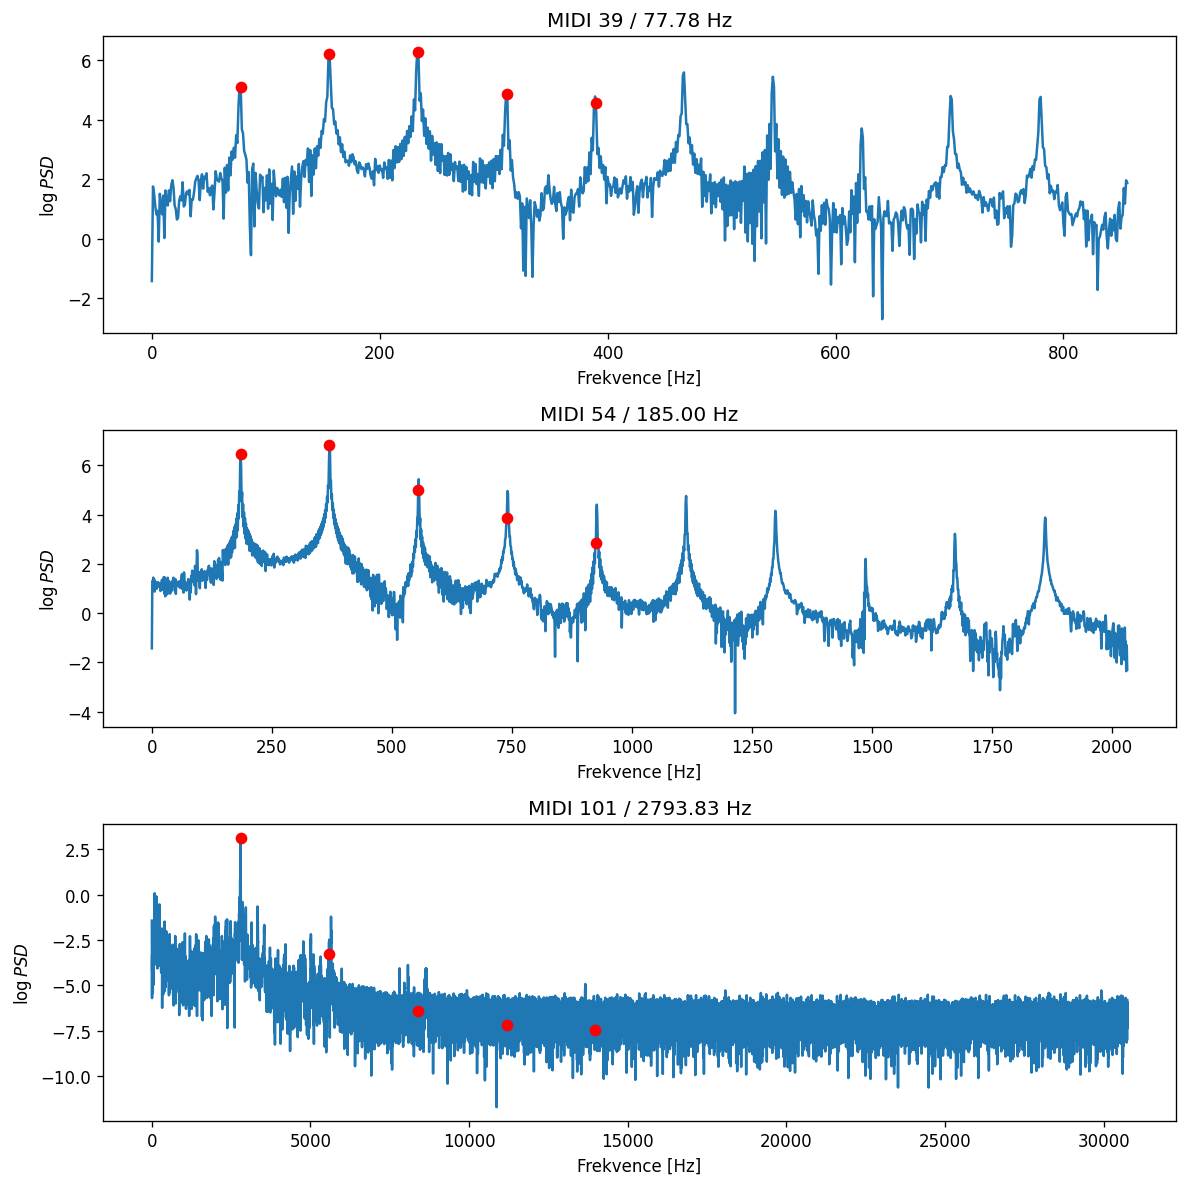

In [139]:
plt.figure(figsize=(10, 10), dpi=120)
for i, (tone, freq) in enumerate(xkucha28t):
    eleven_f0 = int(estimates[tone] * 11)
    dft = np.fft.fft(xall[tone] + 1e-5, Fs)
    dft = dft[:eleven_f0]
    plt.subplot(3, 1, i+1)
    plt.plot(np.log(np.abs(dft)))
    plt.title(f"MIDI {tone} / {freq:.2f} Hz")
    plt.xlabel("Frekvence [Hz]")
    plt.ylabel("$\log PSD$")
    for k in range(0, 5):
        plt.plot((k+1) * estimates[tone], np.log(midi['representation'][tone][k][0]), 'ro')
plt.tight_layout()


# Syntéza tónů

Pro syntézu tónů z reprezentace klavíru jsem použil prosté sčítání cosinusovek. K synchronizování původního a vygenerovaného signálu jsem použil korelaci. Pomocí 5 cosinusovek samozřejmě není možné rekonstruovat všechny zákmity, přesto se vygenerovaný signál se docela pěkně podobá tomu originálnímu. Původní tóny také mírně mění s časem amplitudu a DC offset, což také s touto reprezetací není možné rekonstruovat...

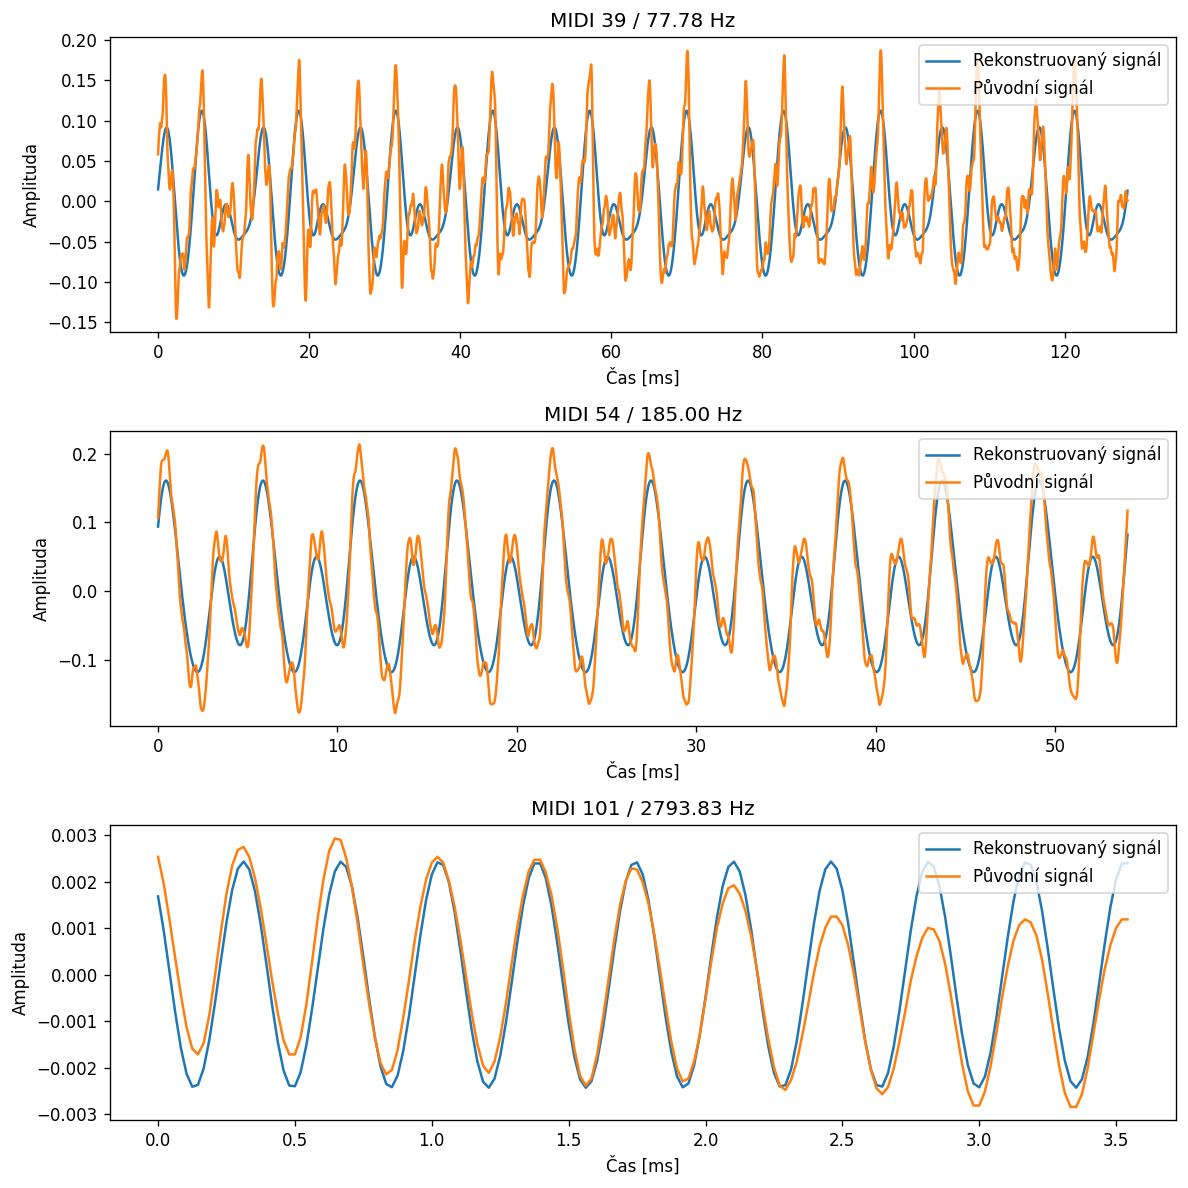

In [140]:
names = ['a', 'b', 'c']
n = np.arange(0, Fs)
plt.figure(figsize=(10, 10), dpi=120)
for i, (tone, freq) in enumerate(xkucha28t):
    # Generate the signal
    res = np.zeros(Fs)
    repre = midi['representation'][tone]
    est = estimates[tone]
    for k in range(0, 5):
        amp = 5 * (repre[k][0] / (Fs))
        cos = np.cos(2 * np.pi * (k+1) * est / Fs * n + repre[k][1])
        res = np.add(res, amp * cos)
    ten_periods = int(Fs / est * 10)
    plot_y = 1000 * np.arange(0, ten_periods) / Fs
    # Calculate offset using correlation
    corr = sig.correlate(xall[tone][:ten_periods], res[:ten_periods])
    corr = corr[len(corr)//2:]
    offset = np.argmax(corr)
    # Plot first 10 periods of original and reconstructed signal
    plt.subplot(3, 1, i+1)
    plt.plot(plot_y, res[:ten_periods])
    plt.plot(plot_y, xall[tone][offset:ten_periods+offset])
    plt.title(f"MIDI {tone} / {freq:.2f} Hz")
    plt.ylabel("Amplituda")
    plt.xlabel("Čas [ms]")
    plt.legend(['Rekonstruovaný signál', 'Původní signál'])
    # Save the signal
    sf.write(f'../audio/{names[i]}.wav', res, Fs)
plt.tight_layout()

# Generování hudby

## Načtení `skladba.txt`
Pro načtení `skladba.txt` jsem použil opět knihovnu Pandas.

In [144]:
song = pd.read_csv(open('skladba.txt', 'r'), sep=' ',
                       header=None, names=['from', 'to', 'midi', 'volume'])
print(song.describe())
length = Fs * 10
#length = int(Fs * song['to'].max() / 1000)
test = np.zeros(length)
for i, line in song.iterrows():
    #line['to'] += 70
    l = int(Fs * (line['to'] - line['from']) / 1000)
    n = np.arange(0, l)
    res = np.zeros(l)
    tone = int(line['midi'])
    repre = midi['representation'][tone]
    est = estimates[tone]
    for k in range(0, 5):
        res = np.add(res, 5 * (repre[k][0] / (Fs)) *
                     np.cos(2 * np.pi * (k+1) * est / Fs * n + repre[k][1]))
    res *= 2 * line['volume'] / 100
    zero_crossings = np.where(np.diff(np.sign(res)) > 0)[0]
    res = res[zero_crossings[0]:zero_crossings[-1]]
    start_pad = int(Fs * line['from'] / 1000) + zero_crossings[0]
    end_pad = length - int(Fs * line['to'] / 1000) + 1000
    if (end_pad < 0):
        end_pad = 0
    res = np.pad(res, (start_pad, end_pad), 'constant', constant_values=(0, 0))
    res = res[:len(test)]
    test = np.add(test, res)
sf.write(f'../audio/out_48k.wav', test, Fs)


                from             to         midi       volume
count    1174.000000    1174.000000  1174.000000  1174.000000
mean    69263.777683   69591.583262    64.873083    46.697615
std     40775.437589   40791.238338    12.439867    15.637181
min         0.000000     225.000000    39.000000    20.000000
25%     33834.375000   34200.000000    53.000000    36.250000
50%     69225.000000   69468.750000    65.000000    48.000000
75%    104400.000000  104850.000000    75.000000    58.000000
max    139500.000000  140400.000000    86.000000    83.000000


# Spektogram
Ze spektrogramu jdou pěkně vidět mezery ve skladbě a do jisté míry i frekvence jednotlivých tonů.

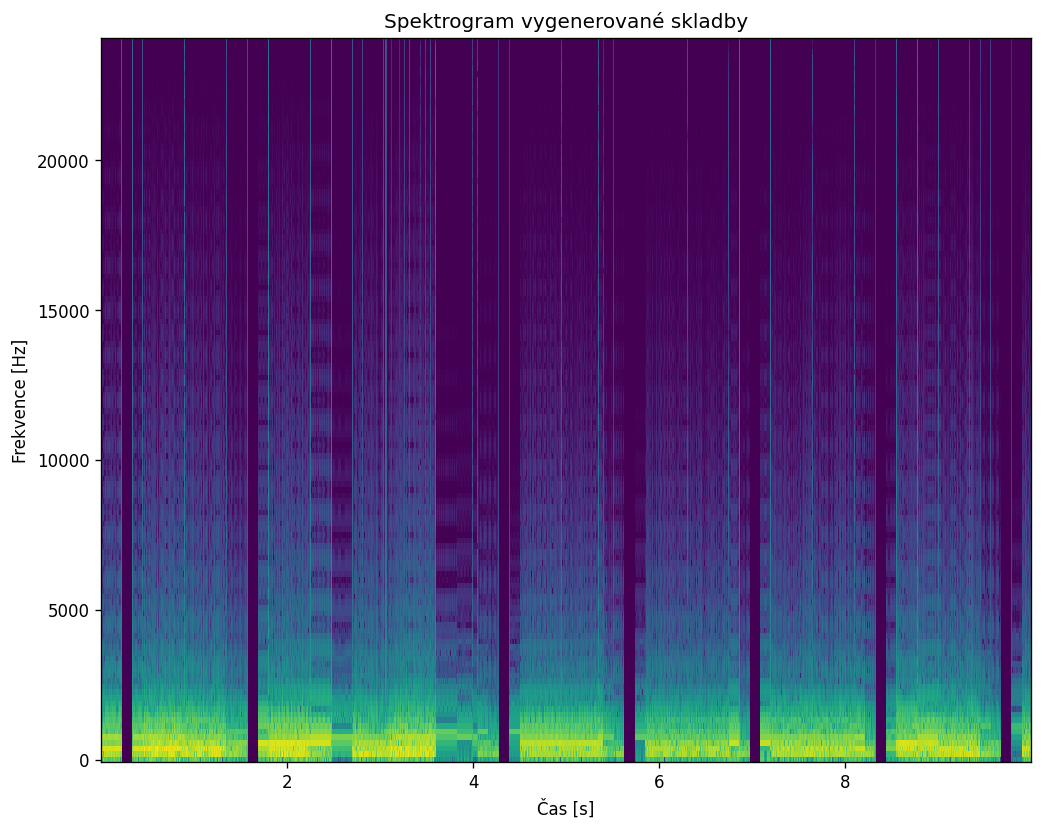

In [143]:
from scipy.signal import spectrogram
f, t, sgr = spectrogram(test, Fs)
sgr_log = 10 * np.log10(sgr+1e-15)
plt.figure(figsize=(10, 8), dpi=120)
plt.pcolormesh(t, f, sgr_log)
plt.xlabel('Čas [s]')
plt.ylabel('Frekvence [Hz]')
plt.title('Spektrogram vygenerované skladby')
plt.show()
